<a href="https://colab.research.google.com/github/nabdeep-patel/flare_cme_association/blob/main/svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from inspect import ClassFoundException
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC

## Standardising the Data

In [2]:
def standardise(flare_data):
  flare_data = np.array(flare_data)
  n_elements = flare_data.shape[0]
  for j in range(flare_data.shape[1]):
      standard_deviation_of_this_feature = np.std(flare_data[:, j])
      median_of_this_feature = np.median(flare_data[:, j])
      for i in range(n_elements):
          flare_data[i, j] = (
              flare_data[i, j] - median_of_this_feature) / (standard_deviation_of_this_feature)
  return flare_data

## Training with SVM

#### Oversampling

In [4]:
param_C = []
param_gamma = []
time_list = []
tss_mean = []
tss_std = []
far_mean = []
far_std = []
fdr_mean = []
fdr_std = []
pod_mean = []
pod_std = []

time = [8,12,24,36,48]

for i in time:
  # Loading the data
  positive = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Non_temporal/positive_class_{i}.csv')
  negative = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Non_temporal/negative_class_{i}.csv')

  positive = positive.iloc[:,5:]
  negative = negative.iloc[:,5:]

  data = pd.concat([positive, negative], axis=0)
  data.columns = ["USFLUX", "MEANGBT", 'MEANJZH', 'MEANPOT', 'SHRGT45', 'TOTUSJH', 'MEANGBH', 'MEANALP', 'MEANGAM', 'MEANGBZ','MEANJZD', 'TOTUSJZ', 'SAVNCPP', 'TOTPOT', 'MEANSHR', 'AREA_ACR', 'R_VALUE', "ABSNJZH"]

  # Adding the target variable
  data["CME"] = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))
  data.reset_index(drop=True, inplace=True)

  # Seperating the data
  xdata = data.iloc[:,:-1]
  ydata = data.iloc[:,-1]

  # Using k = 10
  for C in [0.1, 1, 4, 10, 50, 100]:
    for gamma in [1, 0.1, 0.01, 0.07, 0.001, 0.005, 0.0001]:
      for kernel in ['rbf']:
        skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
        tss_scores = []
        far_scores = []
        fdr_scores = []
        pod_scores = []
        for train_index, test_index in skf.split(xdata, ydata):

          # Test Train Split
          xtrain = xdata.iloc[train_index]
          ytrain = ydata.iloc[train_index]
          xtest = xdata.iloc[test_index]
          ytest = ydata.iloc[test_index]

          # Oversampling
          sm = SMOTE(random_state=42)
          xtrain, ytrain = sm.fit_resample(xtrain, ytrain)

          # Standardisation of Data
          xtrain = standardise(xtrain)
          xtest = standardise(xtest)

          clf = SVC(C=C, gamma=gamma, kernel=kernel, cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
          clf.fit(xtrain, ytrain)
          TN, FP, FN, TP = confusion_matrix(ytest, clf.predict(xtest)).ravel()
          if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
              tss_scores.append(np.nan)
              continue
          elif ((FP+TN) == 0.0):
              far_scores.append(np.nan)
              continue
          elif ((TP+FP) == 0.0):
              fdr_scores.append(np.nan)
              continue
          elif ((TP+FN) == 0.0):
              pod_scores.append(np.nan)
              continue
          else:
              tss_scores.append(TP/(TP+FN) - FP/(FP+TN))
              far_scores.append(FP/(FP+TN))
              fdr_scores.append(FP/(TP+FP))
              pod_scores.append(TP/(TP+FN))

        # Appending the value
        mean_tss = np.nanmean(tss_scores)
        std_tss = np.nanstd(tss_scores)

        tss_mean.append(round(mean_tss, 4))
        tss_std.append(round(std_tss, 4))

        far_mean.append(round(np.nanmean(far_scores), 4))
        far_std.append(round(np.nanstd(far_scores), 4))

        fdr_mean.append(round(np.nanmean(fdr_scores), 4))
        fdr_std.append(round(np.nanstd(fdr_scores), 4))

        pod_mean.append(round(np.nanmean(pod_scores), 4))
        pod_std.append(round(np.nanstd(pod_scores), 4))

        param_C.append(C)
        param_gamma.append(gamma)
        time_list.append(i)
        print(f'Completed for Time: {i}, C:{C}, gamma:{gamma}. Getting TSS:{mean_tss:.4f} \u00B1 {std_tss:.4f}')

# Storing the result
smote_sampling = pd.DataFrame({'C': param_C, 'gamma': param_gamma, 'time': time_list, 'mean_tss': tss_mean, 'std_tss': tss_std, 'mean_far': far_mean, 'std_far': far_std, 'mean_fdr': fdr_mean, 'std_fdr': fdr_std, 'mean_pod': pod_mean, 'std_pod': pod_std})
smote_sampling

Completed for Time: 8, C:0.1, gamma:1. Getting TSS:0.0361 ± 0.1106
Completed for Time: 8, C:0.1, gamma:0.1. Getting TSS:0.0666 ± 0.2034
Completed for Time: 8, C:0.1, gamma:0.01. Getting TSS:0.1063 ± 0.1887
Completed for Time: 8, C:0.1, gamma:0.07. Getting TSS:0.0870 ± 0.1721
Completed for Time: 8, C:0.1, gamma:0.001. Getting TSS:0.0458 ± 0.1749
Completed for Time: 8, C:0.1, gamma:0.005. Getting TSS:0.0631 ± 0.1722
Completed for Time: 8, C:0.1, gamma:0.0001. Getting TSS:0.0470 ± 0.1760
Completed for Time: 8, C:1, gamma:1. Getting TSS:0.0719 ± 0.1472
Completed for Time: 8, C:1, gamma:0.1. Getting TSS:0.0667 ± 0.2450
Completed for Time: 8, C:1, gamma:0.01. Getting TSS:0.1221 ± 0.2049
Completed for Time: 8, C:1, gamma:0.07. Getting TSS:0.0773 ± 0.2123
Completed for Time: 8, C:1, gamma:0.001. Getting TSS:0.1051 ± 0.2048
Completed for Time: 8, C:1, gamma:0.005. Getting TSS:0.1369 ± 0.2066
Completed for Time: 8, C:1, gamma:0.0001. Getting TSS:0.0470 ± 0.1760
Completed for Time: 8, C:4, gamma:

,C,gamma,time,mean_tss,std_tss,mean_far,std_far,mean_fdr,std_fdr,mean_pod,std_pod
0,0.1,1.0000,8,0.0361,0.1106,0.0612,0.0477,0.8148,0.2394,0.0972,0.1288
1,0.1,0.1000,8,0.0666,0.2034,0.3905,0.0818,0.8145,0.0771,0.4571,0.1730
2,0.1,0.0100,8,0.1063,0.1887,0.6670,0.0822,0.8201,0.0357,0.7732,0.1741
3,0.1,0.0700,8,0.0870,0.1721,0.4577,0.0849,0.8146,0.0525,0.5446,0.1679
4,0.1,0.0010,8,0.0458,0.1749,0.6292,0.1453,0.8325,0.0387,0.6750,0.2107
...,...,...,...,...,...,...,...,...,...,...,...
205,100.0,0.0100,48,0.2347,0.2454,0.4278,0.1039,0.7648,0.0798,0.6625,0.2440
206,100.0,0.0700,48,0.1728,0.1462,0.3397,0.1178,0.7621,0.0780,0.5125,0.1972
207,100.0,0.0010,48,0.2193,0.2018,0.5057,0.1232,0.7759,0.0496,0.7250,0.1750
208,100.0,0.0050,48,0.2552,0.1904,0.4573,0.1199,0.7609,0.0510,0.7125,0.1772


In [3]:
param_C = []
param_gamma = []
time_list = []
tss_mean = []
tss_std = []
far_mean = []
far_std = []
fdr_mean = []
fdr_std = []
pod_mean = []
pod_std = []

time = [8,12,24,36,48]

for i in time:
  # Loading the data
  positive = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Non_temporal/positive_class_{i}.csv')
  negative = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Non_temporal/negative_class_{i}.csv')

  positive = positive.iloc[:,5:]
  negative = negative.iloc[:,5:]

  data = pd.concat([positive, negative], axis=0)
  data.columns = ["USFLUX", "MEANGBT", 'MEANJZH', 'MEANPOT', 'SHRGT45', 'TOTUSJH', 'MEANGBH', 'MEANALP', 'MEANGAM', 'MEANGBZ','MEANJZD', 'TOTUSJZ', 'SAVNCPP', 'TOTPOT', 'MEANSHR', 'AREA_ACR', 'R_VALUE', "ABSNJZH"]

  # Adding the target variable
  data["CME"] = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))
  data.reset_index(drop=True, inplace=True)

  # Seperating the data
  xdata = data.iloc[:,:-1]
  ydata = data.iloc[:,-1]

  # Using k = 10
  for C in [0.1, 1, 4, 10, 50, 100]:
    for gamma in [1, 0.1, 0.01, 0.07, 0.001, 0.005, 0.0001]:
      for kernel in ['rbf']:
        skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
        tss_scores = []
        far_scores = []
        fdr_scores = []
        pod_scores = []
        for train_index, test_index in skf.split(xdata, ydata):

          # Test Train Split
          xtrain = xdata.iloc[train_index]
          ytrain = ydata.iloc[train_index]
          xtest = xdata.iloc[test_index]
          ytest = ydata.iloc[test_index]

          # Oversampling
          ROS = RandomOverSampler(random_state=42)
          xtrain, ytrain = ROS.fit_resample(xtrain, ytrain)

          # Standardisation of Data
          xtrain = standardise(xtrain)
          xtest = standardise(xtest)

          clf = SVC(C=C, gamma=gamma, kernel=kernel, cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
          clf.fit(xtrain, ytrain)
          TN, FP, FN, TP = confusion_matrix(ytest, clf.predict(xtest)).ravel()
          if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
              tss_scores.append(np.nan)
              continue
          elif ((FP+TN) == 0.0):
              far_scores.append(np.nan)
              continue
          elif ((TP+FP) == 0.0):
              fdr_scores.append(np.nan)
              continue
          elif ((TP+FN) == 0.0):
              pod_scores.append(np.nan)
              continue
          else:
              tss_scores.append(TP/(TP+FN) - FP/(FP+TN))
              far_scores.append(FP/(FP+TN))
              fdr_scores.append(FP/(TP+FP))
              pod_scores.append(TP/(TP+FN))

        # Appending the value
        mean_tss = np.nanmean(tss_scores)
        std_tss = np.nanstd(tss_scores)

        tss_mean.append(round(mean_tss, 4))
        tss_std.append(round(std_tss, 4))

        far_mean.append(round(np.nanmean(far_scores), 4))
        far_std.append(round(np.nanstd(far_scores), 4))

        fdr_mean.append(round(np.nanmean(fdr_scores), 4))
        fdr_std.append(round(np.nanstd(fdr_scores), 4))

        pod_mean.append(round(np.nanmean(pod_scores), 4))
        pod_std.append(round(np.nanstd(pod_scores), 4))

        param_C.append(C)
        param_gamma.append(gamma)
        time_list.append(i)
        print(f'Completed for Time: {i}, C:{C}, gamma:{gamma}. Getting TSS:{mean_tss:.4f} \u00B1 {std_tss:.4f}')

# Storing the result
ROS_sampling = pd.DataFrame({'C': param_C, 'gamma': param_gamma, 'time': time_list, 'mean_tss': tss_mean, 'std_tss': tss_std, 'mean_far': far_mean, 'std_far': far_std, 'mean_fdr': fdr_mean, 'std_fdr': fdr_std, 'mean_pod': pod_mean, 'std_pod': pod_std})
ROS_sampling

Completed for Time: 8, C:0.1, gamma:1. Getting TSS:0.0211 ± 0.1150
Completed for Time: 8, C:0.1, gamma:0.1. Getting TSS:0.0894 ± 0.2024
Completed for Time: 8, C:0.1, gamma:0.01. Getting TSS:0.1249 ± 0.1452
Completed for Time: 8, C:0.1, gamma:0.07. Getting TSS:0.0938 ± 0.1884
Completed for Time: 8, C:0.1, gamma:0.001. Getting TSS:0.0422 ± 0.1706
Completed for Time: 8, C:0.1, gamma:0.005. Getting TSS:0.1038 ± 0.1976
Completed for Time: 8, C:0.1, gamma:0.0001. Getting TSS:0.0512 ± 0.1709
Completed for Time: 8, C:1, gamma:1. Getting TSS:0.0015 ± 0.1028
Completed for Time: 8, C:1, gamma:0.1. Getting TSS:0.0736 ± 0.2198
Completed for Time: 8, C:1, gamma:0.01. Getting TSS:0.1372 ± 0.2253
Completed for Time: 8, C:1, gamma:0.07. Getting TSS:0.0848 ± 0.2306
Completed for Time: 8, C:1, gamma:0.001. Getting TSS:0.1636 ± 0.1202
Completed for Time: 8, C:1, gamma:0.005. Getting TSS:0.1331 ± 0.1805
Completed for Time: 8, C:1, gamma:0.0001. Getting TSS:0.0512 ± 0.1709
Completed for Time: 8, C:4, gamma:

,C,gamma,time,mean_tss,std_tss,mean_far,std_far,mean_fdr,std_fdr,mean_pod,std_pod
0,0.1,1.0000,8,0.0211,0.1150,0.0289,0.0180,0.8000,0.4000,0.0500,0.1000
1,0.1,0.1000,8,0.0894,0.2024,0.4338,0.0798,0.8136,0.0564,0.5232,0.1804
2,0.1,0.0100,8,0.1249,0.1452,0.5108,0.0863,0.8093,0.0325,0.6357,0.1600
3,0.1,0.0700,8,0.0938,0.1884,0.4794,0.0913,0.8137,0.0499,0.5732,0.1568
4,0.1,0.0010,8,0.0422,0.1706,0.5060,0.0989,0.8351,0.0464,0.5482,0.2153
...,...,...,...,...,...,...,...,...,...,...,...
205,100.0,0.0100,48,0.3113,0.1147,0.3887,0.1426,0.7219,0.0674,0.7000,0.1500
206,100.0,0.0700,48,0.2126,0.1577,0.2999,0.0964,0.7421,0.0743,0.5125,0.1892
207,100.0,0.0010,48,0.2140,0.1597,0.5110,0.0833,0.7804,0.0420,0.7250,0.1458
208,100.0,0.0050,48,0.2951,0.1745,0.4674,0.1181,0.7528,0.0534,0.7625,0.1807


### Undersampling

In [5]:
param_C = []
param_gamma = []
time_list = []
tss_mean = []
tss_std = []
far_mean = []
far_std = []
fdr_mean = []
fdr_std = []
pod_mean = []
pod_std = []

time = [8,12,24,36,48]

for i in time:
  # Loading the data
  positive = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Non_temporal/positive_class_{i}.csv')
  negative = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Non_temporal/negative_class_{i}.csv')

  positive = positive.iloc[:,5:]
  negative = negative.iloc[:,5:]

  data = pd.concat([positive, negative], axis=0)
  data.columns = ["USFLUX", "MEANGBT", 'MEANJZH', 'MEANPOT', 'SHRGT45', 'TOTUSJH', 'MEANGBH', 'MEANALP', 'MEANGAM', 'MEANGBZ','MEANJZD', 'TOTUSJZ', 'SAVNCPP', 'TOTPOT', 'MEANSHR', 'AREA_ACR', 'R_VALUE', "ABSNJZH"]

  # Adding the target variable
  data["CME"] = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))
  data.reset_index(drop=True, inplace=True)

  # Seperating the data
  xdata = data.iloc[:,:-1]
  ydata = data.iloc[:,-1]

  # Using k = 10
  for C in [0.1, 1, 4, 10, 50, 100]:
    for gamma in [1, 0.1, 0.01, 0.07, 0.001, 0.005, 0.0001]:
      for kernel in ['rbf']:
        skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
        tss_scores = []
        far_scores = []
        fdr_scores = []
        pod_scores = []
        for train_index, test_index in skf.split(xdata, ydata):

          # Test Train Split
          xtrain = xdata.iloc[train_index]
          ytrain = ydata.iloc[train_index]
          xtest = xdata.iloc[test_index]
          ytest = ydata.iloc[test_index]

          # Oversampling
          RUS = RandomUnderSampler(random_state=42)
          xtrain, ytrain = RUS.fit_resample(xtrain, ytrain)

          # Standardisation of Data
          xtrain = standardise(xtrain)
          xtest = standardise(xtest)

          clf = SVC(C=C, gamma=gamma, kernel=kernel, cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
          clf.fit(xtrain, ytrain)
          TN, FP, FN, TP = confusion_matrix(ytest, clf.predict(xtest)).ravel()
          if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
              tss_scores.append(np.nan)
              continue
          elif ((FP+TN) == 0.0):
              far_scores.append(np.nan)
              continue
          elif ((TP+FP) == 0.0):
              fdr_scores.append(np.nan)
              continue
          elif ((TP+FN) == 0.0):
              pod_scores.append(np.nan)
              continue
          else:
              tss_scores.append(TP/(TP+FN) - FP/(FP+TN))
              far_scores.append(FP/(FP+TN))
              fdr_scores.append(FP/(TP+FP))
              pod_scores.append(TP/(TP+FN))

        # Appending the value
        mean_tss = np.nanmean(tss_scores)
        std_tss = np.nanstd(tss_scores)

        tss_mean.append(round(mean_tss, 4))
        tss_std.append(round(std_tss, 4))

        far_mean.append(round(np.nanmean(far_scores), 4))
        far_std.append(round(np.nanstd(far_scores), 4))

        fdr_mean.append(round(np.nanmean(fdr_scores), 4))
        fdr_std.append(round(np.nanstd(fdr_scores), 4))

        pod_mean.append(round(np.nanmean(pod_scores), 4))
        pod_std.append(round(np.nanstd(pod_scores), 4))

        param_C.append(C)
        param_gamma.append(gamma)
        time_list.append(i)
        print(f'Completed for Time: {i}, C:{C}, gamma:{gamma}. Getting TSS:{mean_tss:.4f} \u00B1 {std_tss:.4f}')

# Storing the result
RUS_sampling = pd.DataFrame({'C': param_C, 'gamma': param_gamma, 'time': time_list, 'mean_tss': tss_mean, 'std_tss': tss_std, 'mean_far': far_mean, 'std_far': far_std, 'mean_fdr': fdr_mean, 'std_fdr': fdr_std, 'mean_pod': pod_mean, 'std_pod': pod_std})
RUS_sampling

Completed for Time: 8, C:0.1, gamma:1. Getting TSS:0.0994 ± 0.0914
Completed for Time: 8, C:0.1, gamma:0.1. Getting TSS:0.0518 ± 0.1848
Completed for Time: 8, C:0.1, gamma:0.01. Getting TSS:0.0159 ± 0.1574
Completed for Time: 8, C:0.1, gamma:0.07. Getting TSS:0.0731 ± 0.1609
Completed for Time: 8, C:0.1, gamma:0.001. Getting TSS:0.0483 ± 0.1514
Completed for Time: 8, C:0.1, gamma:0.005. Getting TSS:0.0490 ± 0.1313
Completed for Time: 8, C:0.1, gamma:0.0001. Getting TSS:0.0692 ± 0.1662
Completed for Time: 8, C:1, gamma:1. Getting TSS:0.1170 ± 0.1276
Completed for Time: 8, C:1, gamma:0.1. Getting TSS:0.1468 ± 0.2207
Completed for Time: 8, C:1, gamma:0.01. Getting TSS:0.0935 ± 0.1617
Completed for Time: 8, C:1, gamma:0.07. Getting TSS:0.1720 ± 0.2529
Completed for Time: 8, C:1, gamma:0.001. Getting TSS:0.0483 ± 0.1514
Completed for Time: 8, C:1, gamma:0.005. Getting TSS:0.0706 ± 0.1718
Completed for Time: 8, C:1, gamma:0.0001. Getting TSS:0.0692 ± 0.1662
Completed for Time: 8, C:4, gamma:

,C,gamma,time,mean_tss,std_tss,mean_far,std_far,mean_fdr,std_fdr,mean_pod,std_pod
0,0.1,1.0000,8,0.0994,0.0914,0.7113,0.2104,0.8236,0.0200,0.8107,0.2384
1,0.1,0.1000,8,0.0518,0.1848,0.5964,0.1208,0.8311,0.0431,0.6482,0.2132
2,0.1,0.0100,8,0.0159,0.1574,0.5038,0.1154,0.8423,0.0457,0.5196,0.2132
3,0.1,0.0700,8,0.0731,0.1609,0.5609,0.1434,0.8253,0.0403,0.6339,0.2182
4,0.1,0.0010,8,0.0483,0.1514,0.4838,0.1264,0.8357,0.0540,0.5321,0.2224
...,...,...,...,...,...,...,...,...,...,...,...
205,100.0,0.0100,48,0.2981,0.1168,0.4519,0.0794,0.7514,0.0357,0.7500,0.1118
206,100.0,0.0700,48,0.1560,0.1379,0.5065,0.0963,0.7913,0.0439,0.6625,0.1125
207,100.0,0.0010,48,0.2190,0.1160,0.4560,0.1343,0.7636,0.0509,0.6750,0.0829
208,100.0,0.0050,48,0.2590,0.1942,0.4785,0.1124,0.7588,0.0679,0.7375,0.1305


### Class Weight Balance

In [6]:
param_C = []
param_gamma = []
time_list = []
tss_mean = []
tss_std = []
far_mean = []
far_std = []
fdr_mean = []
fdr_std = []
pod_mean = []
pod_std = []

time = [8,12,24,36,48]

for i in time:
  # Loading the data
  positive = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Non_temporal/positive_class_{i}.csv')
  negative = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Non_temporal/negative_class_{i}.csv')

  positive = positive.iloc[:,5:]
  negative = negative.iloc[:,5:]

  data = pd.concat([positive, negative], axis=0)
  data.columns = ["USFLUX", "MEANGBT", 'MEANJZH', 'MEANPOT', 'SHRGT45', 'TOTUSJH', 'MEANGBH', 'MEANALP', 'MEANGAM', 'MEANGBZ','MEANJZD', 'TOTUSJZ', 'SAVNCPP', 'TOTPOT', 'MEANSHR', 'AREA_ACR', 'R_VALUE', "ABSNJZH"]

  # Adding the target variable
  data["CME"] = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))
  data.reset_index(drop=True, inplace=True)

  # Seperating the data
  xdata = data.iloc[:,:-1]
  ydata = data.iloc[:,-1]

  # Using k = 10
  for C in [0.1, 1, 4, 10, 50, 100]:
    for gamma in [1, 0.1, 0.01, 0.07, 0.001, 0.005, 0.0001]:
      for kernel in ['rbf']:
        skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
        tss_scores = []
        far_scores = []
        fdr_scores = []
        pod_scores = []

        for train_index, test_index in skf.split(xdata, ydata):

          # Test Train Split
          xtrain = xdata.iloc[train_index]
          ytrain = ydata.iloc[train_index]
          xtest = xdata.iloc[test_index]
          ytest = ydata.iloc[test_index]

          # Standardisation of Data
          xtrain = standardise(xtrain)
          xtest = standardise(xtest)

          clf = SVC(C=C, gamma=gamma, kernel=kernel, cache_size=500, max_iter=-1,class_weight = 'balanced', shrinking=True, tol=1e-8, probability=True)
          clf.fit(xtrain, ytrain)
          TN, FP, FN, TP = confusion_matrix(ytest, clf.predict(xtest)).ravel()
          if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
              tss_scores.append(np.nan)
              continue
          elif ((FP+TN) == 0.0):
              far_scores.append(np.nan)
              continue
          elif ((TP+FP) == 0.0):
              fdr_scores.append(np.nan)
              continue
          elif ((TP+FN) == 0.0):
              pod_scores.append(np.nan)
              continue
          else:
              tss_scores.append(TP/(TP+FN) - FP/(FP+TN))
              far_scores.append(FP/(FP+TN))
              fdr_scores.append(FP/(TP+FP))
              pod_scores.append(TP/(TP+FN))

        # Appending the value
        mean_tss = np.nanmean(tss_scores)
        std_tss = np.nanstd(tss_scores)

        tss_mean.append(round(mean_tss, 4))
        tss_std.append(round(std_tss, 4))

        far_mean.append(round(np.nanmean(far_scores), 4))
        far_std.append(round(np.nanstd(far_scores), 4))

        fdr_mean.append(round(np.nanmean(fdr_scores), 4))
        fdr_std.append(round(np.nanstd(fdr_scores), 4))

        pod_mean.append(round(np.nanmean(pod_scores), 4))
        pod_std.append(round(np.nanstd(pod_scores), 4))

        param_C.append(C)
        param_gamma.append(gamma)
        time_list.append(i)
        print(f'Completed for Time: {i}, C:{C}, gamma:{gamma}. Getting TSS:{mean_tss:.4f} \u00B1 {std_tss:.4f}')

# Storing the result
cw_sampling = pd.DataFrame({'C': param_C, 'gamma': param_gamma, 'time': time_list, 'mean_tss': tss_mean, 'std_tss': tss_std, 'mean_far': far_mean, 'std_far': far_std, 'mean_fdr': fdr_mean, 'std_fdr': fdr_std, 'mean_pod': pod_mean, 'std_pod': pod_std})
cw_sampling

Completed for Time: 8, C:0.1, gamma:1. Getting TSS:0.0000 ± 0.0000
Completed for Time: 8, C:0.1, gamma:0.1. Getting TSS:0.1856 ± 0.2209
Completed for Time: 8, C:0.1, gamma:0.01. Getting TSS:0.0508 ± 0.1461
Completed for Time: 8, C:0.1, gamma:0.07. Getting TSS:0.1236 ± 0.1858
Completed for Time: 8, C:0.1, gamma:0.001. Getting TSS:0.0000 ± 0.0000
Completed for Time: 8, C:0.1, gamma:0.005. Getting TSS:0.0048 ± 0.0095
Completed for Time: 8, C:0.1, gamma:0.0001. Getting TSS:0.0000 ± 0.0000
Completed for Time: 8, C:1, gamma:1. Getting TSS:0.0422 ± 0.1131
Completed for Time: 8, C:1, gamma:0.1. Getting TSS:0.0684 ± 0.2714
Completed for Time: 8, C:1, gamma:0.01. Getting TSS:0.1334 ± 0.2591
Completed for Time: 8, C:1, gamma:0.07. Getting TSS:0.0918 ± 0.2292
Completed for Time: 8, C:1, gamma:0.001. Getting TSS:0.0394 ± 0.1593
Completed for Time: 8, C:1, gamma:0.005. Getting TSS:0.1634 ± 0.2275
Completed for Time: 8, C:1, gamma:0.0001. Getting TSS:0.0000 ± 0.0000
Completed for Time: 8, C:4, gamma:

/tmp/ipython-input-6-1211804027.py:78: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-6-1211804027.py:84: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-6-1211804027.py:87: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-6-1211804027.py:90: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:0.1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:0.1, gamma:0.1. Getting TSS:0.2018 ± 0.2237
Completed for Time: 36, C:0.1, gamma:0.01. Getting TSS:0.0483 ± 0.1899
Completed for Time: 36, C:0.1, gamma:0.07. Getting TSS:0.1794 ± 0.2416


/tmp/ipython-input-6-1211804027.py:78: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-6-1211804027.py:84: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-6-1211804027.py:87: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-6-1211804027.py:90: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:0.1, gamma:0.001. Getting TSS:nan ± nan
Completed for Time: 36, C:0.1, gamma:0.005. Getting TSS:0.0223 ± 0.0596


/tmp/ipython-input-6-1211804027.py:78: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-6-1211804027.py:84: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-6-1211804027.py:87: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-6-1211804027.py:90: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:0.1, gamma:0.0001. Getting TSS:nan ± nan
Completed for Time: 36, C:1, gamma:1. Getting TSS:0.0326 ± 0.0939
Completed for Time: 36, C:1, gamma:0.1. Getting TSS:0.3343 ± 0.1577
Completed for Time: 36, C:1, gamma:0.01. Getting TSS:0.1443 ± 0.2223
Completed for Time: 36, C:1, gamma:0.07. Getting TSS:0.3679 ± 0.1778
Completed for Time: 36, C:1, gamma:0.001. Getting TSS:0.1174 ± 0.2317
Completed for Time: 36, C:1, gamma:0.005. Getting TSS:0.1953 ± 0.2381


/tmp/ipython-input-6-1211804027.py:78: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-6-1211804027.py:84: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-6-1211804027.py:87: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-6-1211804027.py:90: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:1, gamma:0.0001. Getting TSS:nan ± nan
Completed for Time: 36, C:4, gamma:1. Getting TSS:0.0110 ± 0.0530
Completed for Time: 36, C:4, gamma:0.1. Getting TSS:0.2165 ± 0.1877
Completed for Time: 36, C:4, gamma:0.01. Getting TSS:0.2768 ± 0.1647
Completed for Time: 36, C:4, gamma:0.07. Getting TSS:0.2889 ± 0.1692
Completed for Time: 36, C:4, gamma:0.001. Getting TSS:0.2151 ± 0.2262
Completed for Time: 36, C:4, gamma:0.005. Getting TSS:0.2044 ± 0.2446
Completed for Time: 36, C:4, gamma:0.0001. Getting TSS:0.0380 ± 0.0743
Completed for Time: 36, C:10, gamma:1. Getting TSS:0.0110 ± 0.0530
Completed for Time: 36, C:10, gamma:0.1. Getting TSS:0.2124 ± 0.1372
Completed for Time: 36, C:10, gamma:0.01. Getting TSS:0.2564 ± 0.1889
Completed for Time: 36, C:10, gamma:0.07. Getting TSS:0.2720 ± 0.1315
Completed for Time: 36, C:10, gamma:0.001. Getting TSS:0.2024 ± 0.2008
Completed for Time: 36, C:10, gamma:0.005. Getting TSS:0.2438 ± 0.1878
Completed for Time: 36, C:10, gamm

/tmp/ipython-input-6-1211804027.py:78: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-6-1211804027.py:84: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-6-1211804027.py:87: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-6-1211804027.py:90: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 48, C:1, gamma:0.0001. Getting TSS:nan ± nan
Completed for Time: 48, C:4, gamma:1. Getting TSS:0.0787 ± 0.1102
Completed for Time: 48, C:4, gamma:0.1. Getting TSS:0.2904 ± 0.1192
Completed for Time: 48, C:4, gamma:0.01. Getting TSS:0.2757 ± 0.1593
Completed for Time: 48, C:4, gamma:0.07. Getting TSS:0.3505 ± 0.1267
Completed for Time: 48, C:4, gamma:0.001. Getting TSS:0.1530 ± 0.1822
Completed for Time: 48, C:4, gamma:0.005. Getting TSS:0.2214 ± 0.1857
Completed for Time: 48, C:4, gamma:0.0001. Getting TSS:0.0453 ± 0.0811
Completed for Time: 48, C:10, gamma:1. Getting TSS:0.0943 ± 0.1031
Completed for Time: 48, C:10, gamma:0.1. Getting TSS:0.1946 ± 0.1609
Completed for Time: 48, C:10, gamma:0.01. Getting TSS:0.3210 ± 0.2107
Completed for Time: 48, C:10, gamma:0.07. Getting TSS:0.2851 ± 0.1355
Completed for Time: 48, C:10, gamma:0.001. Getting TSS:0.2047 ± 0.1647
Completed for Time: 48, C:10, gamma:0.005. Getting TSS:0.2436 ± 0.1504
Completed for Time: 48, C:10, gamm

,C,gamma,time,mean_tss,std_tss,mean_far,std_far,mean_fdr,std_fdr,mean_pod,std_pod
0,0.1,1.0000,8,0.0000,0.0000,1.0000,0.0000,0.8407,0.0057,1.0000,0.0000
1,0.1,0.1000,8,0.1856,0.2209,0.4626,0.0800,0.7901,0.0599,0.6482,0.2058
2,0.1,0.0100,8,0.0508,0.1461,0.7992,0.1368,0.8321,0.0327,0.8500,0.1837
3,0.1,0.0700,8,0.1236,0.1858,0.4603,0.0756,0.8059,0.0528,0.5839,0.1742
4,0.1,0.0010,8,0.0000,0.0000,1.0000,0.0000,0.8407,0.0057,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
205,100.0,0.0100,48,0.3175,0.1952,0.3075,0.1236,0.7033,0.0860,0.6250,0.2092
206,100.0,0.0700,48,0.1640,0.1170,0.2485,0.0948,0.7454,0.0678,0.4125,0.1375
207,100.0,0.0010,48,0.2907,0.1541,0.3218,0.0877,0.7252,0.0569,0.6125,0.1718
208,100.0,0.0050,48,0.2957,0.1781,0.3418,0.1302,0.7208,0.0788,0.6375,0.1972


## Best TSS

In [11]:
# Getting the best TSS row for each timestamp

sampling_methods = [cw_sampling, smote_sampling, ROS_sampling, RUS_sampling]
sampling_names = ["cw_sampling", "smote_sampling", "ROS_sampling", "RUS_sampling"]

for j, name in zip(sampling_methods, sampling_names):
  list_best_rows = []
  for i in j['time'].unique():
    time_subset = j[j['time'] == i]
    best_tss_row = time_subset.loc[time_subset['mean_tss'].idxmax()]
    list_best_rows.append(best_tss_row)

  best_tss_df = pd.DataFrame(list_best_rows).reset_index(drop=True)
  print(f"Best TSS rows for {name}:")
  print(best_tss_df)
  print("\n")
  best_tss_df.to_csv(f'/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_{name}.csv')

Best TSS rows for cw_sampling:
       C  gamma  time  mean_tss  std_tss  mean_far  std_far  mean_fdr  \
0  100.0  0.001   8.0    0.2688   0.2113    0.4294   0.0946    0.7594   
1   10.0  0.010  12.0    0.3321   0.1242    0.3443   0.0813    0.7119   
2   10.0  0.001  24.0    0.2674   0.1721    0.3665   0.0644    0.7574   
3    1.0  0.070  36.0    0.3679   0.1778    0.3112   0.0373    0.6877   
4   50.0  0.010  48.0    0.3555   0.1710    0.3320   0.1237    0.6962   

   std_fdr  mean_pod  std_pod  
0   0.0704    0.6982   0.1769  
1   0.0637    0.6764   0.0968  
2   0.0618    0.6339   0.1698  
3   0.0697    0.6792   0.1580  
4   0.0804    0.6875   0.1700  


Best TSS rows for smote_sampling:
       C   gamma  time  mean_tss  std_tss  mean_far  std_far  mean_fdr  \
0  100.0  0.0001   8.0    0.2172   0.2250    0.5060   0.0912    0.7819   
1   10.0  0.0050  12.0    0.3247   0.1695    0.4114   0.0522    0.7374   
2    4.0  0.0100  24.0    0.1944   0.1317    0.4788   0.0621    0.7950   
3   10

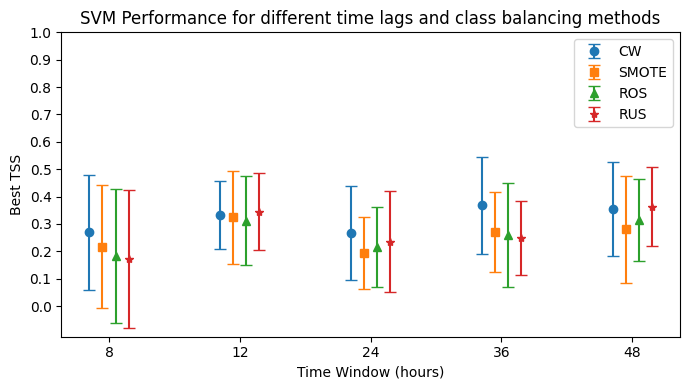

In [12]:
# Read the best TSS including temporal features for differernt sampling methods
cw = pd.read_csv('/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_cw_sampling.csv')
smote = pd.read_csv('/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_smote_sampling.csv')
ROS = pd.read_csv('/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_ROS_sampling.csv')
RUS = pd.read_csv('/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_RUS_sampling.csv')

# Drop the unnamed index column
cw = cw.drop(columns=['Unnamed: 0'])
smote = smote.drop(columns=['Unnamed: 0'])
ROS = ROS.drop(columns=['Unnamed: 0'])
RUS = RUS.drop(columns=['Unnamed: 0'])

base_times = np.arange(len(cw['time']))
offset = 0.1

# Apply small shifts to x positions
cw_time     = base_times - 1.5 * offset
smote_time  = base_times - 0.5 * offset
ros_time    = base_times + 0.5 * offset
rus_time    = base_times + 1.5 * offset

# Create the plot
plt.figure(figsize=(7, 4))

# Plot temporal TSS (using the time points from temporal data)
plt.errorbar(cw_time, cw["mean_tss"], yerr= cw['std_tss'], marker='o',linestyle='None', label='CW',capsize=4)
plt.errorbar(smote_time, smote["mean_tss"], yerr= smote['std_tss'], marker='s',linestyle='None', label='SMOTE',capsize=4)
plt.errorbar(ros_time, ROS["mean_tss"], yerr= ROS['std_tss'], marker='^',linestyle='None', label='ROS',capsize=4)
plt.errorbar(rus_time, RUS["mean_tss"], yerr= RUS['std_tss'], marker='*',linestyle='None', label='RUS',capsize=4)

plt.title('SVM Performance for different time lags and class balancing methods')
plt.xlabel('Time Window (hours)')
plt.ylabel('Best TSS')
plt.xticks(base_times, [8,12,24,36,48])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Research/Google Colab/Hemapriya Raju 2023/analysis/svm/tss_comparison.png')
plt.show()

## Using Temporal Data

## Training with SVM

#### Oversampling

In [15]:
param_C = []
param_gamma = []
time_list = []
tss_mean = []
tss_std = []
far_mean = []
far_std = []
fdr_mean = []
fdr_std = []
pod_mean = []
pod_std = []

time = [12,24,36]

for i in time:
  # Loading the data
  positive = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Temporal/positive_class_final_{i}.csv')
  negative = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Temporal/negative_class_final_{i}.csv')

  # Drop rows with NaN values
  positive.dropna(inplace=True)
  negative.dropna(inplace=True)

  positive = positive.iloc[:,5:]
  negative = negative.iloc[:,5:]

  data = pd.concat([positive, negative], axis=0)

  # Adding the target variable
  data["CME"] = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))
  data.reset_index(drop=True, inplace=True)

  # Seperating the data
  xdata = data.iloc[:,:-1]
  ydata = data.iloc[:,-1]

  # Using k = 10
  for C in [0.1, 1, 4, 10, 50, 100]:
    for gamma in [1, 0.1, 0.01, 0.07, 0.001, 0.005, 0.0001]:
      for kernel in ['rbf']:
        skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
        tss_scores = []
        far_scores = []
        fdr_scores = []
        pod_scores = []
        for train_index, test_index in skf.split(xdata, ydata):

          # Test Train Split
          xtrain = xdata.iloc[train_index]
          ytrain = ydata.iloc[train_index]
          xtest = xdata.iloc[test_index]
          ytest = ydata.iloc[test_index]

          # Oversampling
          sm = SMOTE(random_state=42)
          xtrain, ytrain = sm.fit_resample(xtrain, ytrain)

          # Standardisation of Data
          xtrain = standardise(xtrain)
          xtest = standardise(xtest)

          clf = SVC(C=C, gamma=gamma, kernel=kernel, cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
          clf.fit(xtrain, ytrain)
          TN, FP, FN, TP = confusion_matrix(ytest, clf.predict(xtest)).ravel()
          if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
              tss_scores.append(np.nan)
              continue
          elif ((FP+TN) == 0.0):
              far_scores.append(np.nan)
              continue
          elif ((TP+FP) == 0.0):
              fdr_scores.append(np.nan)
              continue
          elif ((TP+FN) == 0.0):
              pod_scores.append(np.nan)
              continue
          else:
              tss_scores.append(TP/(TP+FN) - FP/(FP+TN))
              far_scores.append(FP/(FP+TN))
              fdr_scores.append(FP/(TP+FP))
              pod_scores.append(TP/(TP+FN))

        # Appending the value
        mean_tss = np.nanmean(tss_scores)
        std_tss = np.nanstd(tss_scores)

        tss_mean.append(round(mean_tss, 4))
        tss_std.append(round(std_tss, 4))

        far_mean.append(round(np.nanmean(far_scores), 4))
        far_std.append(round(np.nanstd(far_scores), 4))

        fdr_mean.append(round(np.nanmean(fdr_scores), 4))
        fdr_std.append(round(np.nanstd(fdr_scores), 4))

        pod_mean.append(round(np.nanmean(pod_scores), 4))
        pod_std.append(round(np.nanstd(pod_scores), 4))

        param_C.append(C)
        param_gamma.append(gamma)
        time_list.append(i)
        print(f'Completed for Time: {i}, C:{C}, gamma:{gamma}. Getting TSS:{mean_tss:.4f} \u00B1 {std_tss:.4f}')

# Storing the result
smote_sampling = pd.DataFrame({'C': param_C, 'gamma': param_gamma, 'time': time_list, 'mean_tss': tss_mean, 'std_tss': tss_std, 'mean_far': far_mean, 'std_far': far_std, 'mean_fdr': fdr_mean, 'std_fdr': fdr_std, 'mean_pod': pod_mean, 'std_pod': pod_std})
smote_sampling

/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:0.1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:0.1, gamma:0.1. Getting TSS:0.0471 ± 0.1241
Completed for Time: 12, C:0.1, gamma:0.01. Getting TSS:0.0998 ± 0.2213
Completed for Time: 12, C:0.1, gamma:0.07. Getting TSS:0.0875 ± 0.1411
Completed for Time: 12, C:0.1, gamma:0.001. Getting TSS:0.0787 ± 0.2424
Completed for Time: 12, C:0.1, gamma:0.005. Getting TSS:0.0654 ± 0.2438
Completed for Time: 12, C:0.1, gamma:0.0001. Getting TSS:0.0885 ± 0.2472
Completed for Time: 12, C:1, gamma:1. Getting TSS:0.1429 ± 0.0000
Completed for Time: 12, C:1, gamma:0.1. Getting TSS:0.0810 ± 0.1289
Completed for Time: 12, C:1, gamma:0.01. Getting TSS:0.1939 ± 0.2365
Completed for Time: 12, C:1, gamma:0.07. Getting TSS:0.0841 ± 0.1604
Completed for Time: 12, C:1, gamma:0.001. Getting TSS:0.1837 ± 0.2541
Completed for Time: 12, C:1, gamma:0.005. Getting TSS:0.1581 ± 0.2607
Completed for Time: 12, C:1, gamma:0.0001. Getting TSS:0.0885 ± 0.2472
Completed for Time: 12, C:

/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:0.1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:0.1, gamma:0.1. Getting TSS:-0.0094 ± 0.1057
Completed for Time: 24, C:0.1, gamma:0.01. Getting TSS:0.1149 ± 0.1929
Completed for Time: 24, C:0.1, gamma:0.07. Getting TSS:0.0333 ± 0.0871
Completed for Time: 24, C:0.1, gamma:0.001. Getting TSS:0.1083 ± 0.1405
Completed for Time: 24, C:0.1, gamma:0.005. Getting TSS:0.0936 ± 0.2506
Completed for Time: 24, C:0.1, gamma:0.0001. Getting TSS:0.1012 ± 0.1475


/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:1, gamma:0.1. Getting TSS:0.1065 ± 0.1636
Completed for Time: 24, C:1, gamma:0.01. Getting TSS:0.1935 ± 0.1975
Completed for Time: 24, C:1, gamma:0.07. Getting TSS:0.1280 ± 0.1300
Completed for Time: 24, C:1, gamma:0.001. Getting TSS:0.1453 ± 0.2359
Completed for Time: 24, C:1, gamma:0.005. Getting TSS:0.1765 ± 0.2330
Completed for Time: 24, C:1, gamma:0.0001. Getting TSS:0.1012 ± 0.1475
Completed for Time: 24, C:4, gamma:1. Getting TSS:0.1429 ± 0.0000
Completed for Time: 24, C:4, gamma:0.1. Getting TSS:0.0690 ± 0.1209
Completed for Time: 24, C:4, gamma:0.01. Getting TSS:0.2228 ± 0.2298
Completed for Time: 24, C:4, gamma:0.07. Getting TSS:0.1210 ± 0.1329
Completed for Time: 24, C:4, gamma:0.001. Getting TSS:0.2111 ± 0.2368
Completed for Time: 24, C:4, gamma:0.005. Getting TSS:0.2424 ± 0.2061
Completed for Time: 24, C:4, gamma:0.0001. Getting TSS:0.0937 ± 0.1989
Completed for Time: 24, C:10, gamma:1. G

/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:0.1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:0.1, gamma:0.1. Getting TSS:0.1148 ± 0.1408
Completed for Time: 36, C:0.1, gamma:0.01. Getting TSS:0.0734 ± 0.0896
Completed for Time: 36, C:0.1, gamma:0.07. Getting TSS:0.1522 ± 0.1111
Completed for Time: 36, C:0.1, gamma:0.001. Getting TSS:0.0282 ± 0.0689
Completed for Time: 36, C:0.1, gamma:0.005. Getting TSS:0.0444 ± 0.1242
Completed for Time: 36, C:0.1, gamma:0.0001. Getting TSS:0.0362 ± 0.0683


/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:1, gamma:0.1. Getting TSS:0.1567 ± 0.1476
Completed for Time: 36, C:1, gamma:0.01. Getting TSS:0.1968 ± 0.1334
Completed for Time: 36, C:1, gamma:0.07. Getting TSS:0.2271 ± 0.1332
Completed for Time: 36, C:1, gamma:0.001. Getting TSS:0.1052 ± 0.1385
Completed for Time: 36, C:1, gamma:0.005. Getting TSS:0.1626 ± 0.1268
Completed for Time: 36, C:1, gamma:0.0001. Getting TSS:0.0362 ± 0.0683


/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:4, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:4, gamma:0.1. Getting TSS:0.1273 ± 0.1502
Completed for Time: 36, C:4, gamma:0.01. Getting TSS:0.2158 ± 0.1567
Completed for Time: 36, C:4, gamma:0.07. Getting TSS:0.1636 ± 0.1299
Completed for Time: 36, C:4, gamma:0.001. Getting TSS:0.1536 ± 0.1310
Completed for Time: 36, C:4, gamma:0.005. Getting TSS:0.1744 ± 0.1485
Completed for Time: 36, C:4, gamma:0.0001. Getting TSS:0.0691 ± 0.1570


/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:10, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:10, gamma:0.1. Getting TSS:0.1300 ± 0.1481
Completed for Time: 36, C:10, gamma:0.01. Getting TSS:0.2461 ± 0.1591
Completed for Time: 36, C:10, gamma:0.07. Getting TSS:0.1225 ± 0.1201
Completed for Time: 36, C:10, gamma:0.001. Getting TSS:0.1260 ± 0.1494
Completed for Time: 36, C:10, gamma:0.005. Getting TSS:0.2308 ± 0.1417
Completed for Time: 36, C:10, gamma:0.0001. Getting TSS:0.1179 ± 0.1615


/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:50, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:50, gamma:0.1. Getting TSS:0.1300 ± 0.1481
Completed for Time: 36, C:50, gamma:0.01. Getting TSS:0.2167 ± 0.1598
Completed for Time: 36, C:50, gamma:0.07. Getting TSS:0.1198 ± 0.1216
Completed for Time: 36, C:50, gamma:0.001. Getting TSS:0.1804 ± 0.1604
Completed for Time: 36, C:50, gamma:0.005. Getting TSS:0.2184 ± 0.1926
Completed for Time: 36, C:50, gamma:0.0001. Getting TSS:0.1653 ± 0.1563


/tmp/ipython-input-15-461337010.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-15-461337010.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-15-461337010.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-15-461337010.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:100, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:100, gamma:0.1. Getting TSS:0.1300 ± 0.1481
Completed for Time: 36, C:100, gamma:0.01. Getting TSS:0.2435 ± 0.2133
Completed for Time: 36, C:100, gamma:0.07. Getting TSS:0.1198 ± 0.1216
Completed for Time: 36, C:100, gamma:0.001. Getting TSS:0.2110 ± 0.1538
Completed for Time: 36, C:100, gamma:0.005. Getting TSS:0.2185 ± 0.1898
Completed for Time: 36, C:100, gamma:0.0001. Getting TSS:0.1697 ± 0.2004


,C,gamma,time,mean_tss,std_tss,mean_far,std_far,mean_fdr,std_fdr,mean_pod,std_pod
0,0.1,1.0000,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.1000,12,0.0471,0.1241,0.0898,0.0647,0.7704,0.2144,0.1369,0.1123
2,0.1,0.0100,12,0.0998,0.2213,0.5984,0.0754,0.8202,0.0522,0.6982,0.2146
3,0.1,0.0700,12,0.0875,0.1411,0.1715,0.0742,0.7632,0.1179,0.2589,0.1291
4,0.1,0.0010,12,0.0787,0.2424,0.7302,0.0757,0.8260,0.0493,0.8089,0.2033
...,...,...,...,...,...,...,...,...,...,...,...
121,100.0,0.0100,36,0.2435,0.2133,0.2422,0.0681,0.7074,0.1039,0.4857,0.1826
122,100.0,0.0700,36,0.1198,0.1216,0.1481,0.0461,0.7369,0.0842,0.2679,0.1253
123,100.0,0.0010,36,0.2110,0.1538,0.4408,0.0602,0.7675,0.0511,0.6518,0.1099
124,100.0,0.0050,36,0.2185,0.1898,0.3065,0.0773,0.7368,0.0824,0.5250,0.1503


In [16]:
param_C = []
param_gamma = []
time_list = []
tss_mean = []
tss_std = []
far_mean = []
far_std = []
fdr_mean = []
fdr_std = []
pod_mean = []
pod_std = []

time = [12,24,36]

for i in time:
  # Loading the data
  positive = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Temporal/positive_class_final_{i}.csv')
  negative = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Temporal/negative_class_final_{i}.csv')

  # Drop rows with NaN values
  positive.dropna(inplace=True)
  negative.dropna(inplace=True)

  positive = positive.iloc[:,5:]
  negative = negative.iloc[:,5:]

  data = pd.concat([positive, negative], axis=0)

  # Adding the target variable
  data["CME"] = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))
  data.reset_index(drop=True, inplace=True)

  # Seperating the data
  xdata = data.iloc[:,:-1]
  ydata = data.iloc[:,-1]

  # Using k = 10
  for C in [0.1, 1, 4, 10, 50, 100]:
    for gamma in [1, 0.1, 0.01, 0.07, 0.001, 0.005, 0.0001]:
      for kernel in ['rbf']:
        skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
        tss_scores = []
        far_scores = []
        fdr_scores = []
        pod_scores = []
        for train_index, test_index in skf.split(xdata, ydata):

          # Test Train Split
          xtrain = xdata.iloc[train_index]
          ytrain = ydata.iloc[train_index]
          xtest = xdata.iloc[test_index]
          ytest = ydata.iloc[test_index]

          # Oversampling
          ROS = RandomOverSampler(random_state=42)
          xtrain, ytrain = ROS.fit_resample(xtrain, ytrain)

          # Standardisation of Data
          xtrain = standardise(xtrain)
          xtest = standardise(xtest)

          clf = SVC(C=C, gamma=gamma, kernel=kernel, cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
          clf.fit(xtrain, ytrain)
          TN, FP, FN, TP = confusion_matrix(ytest, clf.predict(xtest)).ravel()
          if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
              tss_scores.append(np.nan)
              continue
          elif ((FP+TN) == 0.0):
              far_scores.append(np.nan)
              continue
          elif ((TP+FP) == 0.0):
              fdr_scores.append(np.nan)
              continue
          elif ((TP+FN) == 0.0):
              pod_scores.append(np.nan)
              continue
          else:
              tss_scores.append(TP/(TP+FN) - FP/(FP+TN))
              far_scores.append(FP/(FP+TN))
              fdr_scores.append(FP/(TP+FP))
              pod_scores.append(TP/(TP+FN))

        # Appending the value
        mean_tss = np.nanmean(tss_scores)
        std_tss = np.nanstd(tss_scores)

        tss_mean.append(round(mean_tss, 4))
        tss_std.append(round(std_tss, 4))

        far_mean.append(round(np.nanmean(far_scores), 4))
        far_std.append(round(np.nanstd(far_scores), 4))

        fdr_mean.append(round(np.nanmean(fdr_scores), 4))
        fdr_std.append(round(np.nanstd(fdr_scores), 4))

        pod_mean.append(round(np.nanmean(pod_scores), 4))
        pod_std.append(round(np.nanstd(pod_scores), 4))

        param_C.append(C)
        param_gamma.append(gamma)
        time_list.append(i)
        print(f'Completed for Time: {i}, C:{C}, gamma:{gamma}. Getting TSS:{mean_tss:.4f} \u00B1 {std_tss:.4f}')

# Storing the result
ROS_sampling = pd.DataFrame({'C': param_C, 'gamma': param_gamma, 'time': time_list, 'mean_tss': tss_mean, 'std_tss': tss_std, 'mean_far': far_mean, 'std_far': far_std, 'mean_fdr': fdr_mean, 'std_fdr': fdr_std, 'mean_pod': pod_mean, 'std_pod': pod_std})
ROS_sampling

/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:0.1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:0.1, gamma:0.1. Getting TSS:0.1876 ± 0.1478
Completed for Time: 12, C:0.1, gamma:0.01. Getting TSS:0.1358 ± 0.2750
Completed for Time: 12, C:0.1, gamma:0.07. Getting TSS:0.1243 ± 0.2221
Completed for Time: 12, C:0.1, gamma:0.001. Getting TSS:0.0452 ± 0.1950
Completed for Time: 12, C:0.1, gamma:0.005. Getting TSS:0.0975 ± 0.2244
Completed for Time: 12, C:0.1, gamma:0.0001. Getting TSS:0.0034 ± 0.2020


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:1, gamma:0.1. Getting TSS:0.0590 ± 0.1003
Completed for Time: 12, C:1, gamma:0.01. Getting TSS:0.1688 ± 0.2298
Completed for Time: 12, C:1, gamma:0.07. Getting TSS:0.1543 ± 0.1653
Completed for Time: 12, C:1, gamma:0.001. Getting TSS:0.1922 ± 0.2443
Completed for Time: 12, C:1, gamma:0.005. Getting TSS:0.1875 ± 0.1909
Completed for Time: 12, C:1, gamma:0.0001. Getting TSS:0.0034 ± 0.2020


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:4, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:4, gamma:0.1. Getting TSS:0.1099 ± 0.1468
Completed for Time: 12, C:4, gamma:0.01. Getting TSS:0.1470 ± 0.1821
Completed for Time: 12, C:4, gamma:0.07. Getting TSS:0.1218 ± 0.1570
Completed for Time: 12, C:4, gamma:0.001. Getting TSS:0.2344 ± 0.2134
Completed for Time: 12, C:4, gamma:0.005. Getting TSS:0.1570 ± 0.1548
Completed for Time: 12, C:4, gamma:0.0001. Getting TSS:0.0287 ± 0.2110


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:10, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:10, gamma:0.1. Getting TSS:0.1062 ± 0.1510
Completed for Time: 12, C:10, gamma:0.01. Getting TSS:0.1942 ± 0.2154
Completed for Time: 12, C:10, gamma:0.07. Getting TSS:0.1347 ± 0.1797
Completed for Time: 12, C:10, gamma:0.001. Getting TSS:0.1632 ± 0.1508
Completed for Time: 12, C:10, gamma:0.005. Getting TSS:0.2195 ± 0.1703
Completed for Time: 12, C:10, gamma:0.0001. Getting TSS:0.1981 ± 0.2159


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:50, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:50, gamma:0.1. Getting TSS:0.0921 ± 0.1514
Completed for Time: 12, C:50, gamma:0.01. Getting TSS:0.2348 ± 0.2605
Completed for Time: 12, C:50, gamma:0.07. Getting TSS:0.1377 ± 0.1796
Completed for Time: 12, C:50, gamma:0.001. Getting TSS:0.1913 ± 0.1170
Completed for Time: 12, C:50, gamma:0.005. Getting TSS:0.1742 ± 0.2253
Completed for Time: 12, C:50, gamma:0.0001. Getting TSS:0.2369 ± 0.2060


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:100, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:100, gamma:0.1. Getting TSS:0.0921 ± 0.1514
Completed for Time: 12, C:100, gamma:0.01. Getting TSS:0.1985 ± 0.2141
Completed for Time: 12, C:100, gamma:0.07. Getting TSS:0.1377 ± 0.1796
Completed for Time: 12, C:100, gamma:0.001. Getting TSS:0.1794 ± 0.1696
Completed for Time: 12, C:100, gamma:0.005. Getting TSS:0.1969 ± 0.2360
Completed for Time: 12, C:100, gamma:0.0001. Getting TSS:0.1972 ± 0.2101


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:0.1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:0.1, gamma:0.1. Getting TSS:0.0996 ± 0.1466
Completed for Time: 24, C:0.1, gamma:0.01. Getting TSS:0.0986 ± 0.1993
Completed for Time: 24, C:0.1, gamma:0.07. Getting TSS:0.1599 ± 0.1960
Completed for Time: 24, C:0.1, gamma:0.001. Getting TSS:0.1286 ± 0.1970
Completed for Time: 24, C:0.1, gamma:0.005. Getting TSS:0.1101 ± 0.1802
Completed for Time: 24, C:0.1, gamma:0.0001. Getting TSS:0.1084 ± 0.2021


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:1, gamma:0.1. Getting TSS:0.0823 ± 0.1316
Completed for Time: 24, C:1, gamma:0.01. Getting TSS:0.1704 ± 0.2173
Completed for Time: 24, C:1, gamma:0.07. Getting TSS:0.1032 ± 0.1489
Completed for Time: 24, C:1, gamma:0.001. Getting TSS:0.1178 ± 0.2455
Completed for Time: 24, C:1, gamma:0.005. Getting TSS:0.1644 ± 0.2195
Completed for Time: 24, C:1, gamma:0.0001. Getting TSS:0.1084 ± 0.2021


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:4, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:4, gamma:0.1. Getting TSS:0.1127 ± 0.1518
Completed for Time: 24, C:4, gamma:0.01. Getting TSS:0.2157 ± 0.2393
Completed for Time: 24, C:4, gamma:0.07. Getting TSS:0.1022 ± 0.1730
Completed for Time: 24, C:4, gamma:0.001. Getting TSS:0.1734 ± 0.2333
Completed for Time: 24, C:4, gamma:0.005. Getting TSS:0.1702 ± 0.2016
Completed for Time: 24, C:4, gamma:0.0001. Getting TSS:0.0554 ± 0.1914


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:10, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:10, gamma:0.1. Getting TSS:0.0869 ± 0.1153
Completed for Time: 24, C:10, gamma:0.01. Getting TSS:0.1861 ± 0.2404
Completed for Time: 24, C:10, gamma:0.07. Getting TSS:0.0906 ± 0.1417
Completed for Time: 24, C:10, gamma:0.001. Getting TSS:0.1715 ± 0.1969
Completed for Time: 24, C:10, gamma:0.005. Getting TSS:0.1684 ± 0.1901
Completed for Time: 24, C:10, gamma:0.0001. Getting TSS:0.1481 ± 0.2407


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:50, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:50, gamma:0.1. Getting TSS:0.0842 ± 0.1182
Completed for Time: 24, C:50, gamma:0.01. Getting TSS:0.1030 ± 0.1568
Completed for Time: 24, C:50, gamma:0.07. Getting TSS:0.0816 ± 0.1422
Completed for Time: 24, C:50, gamma:0.001. Getting TSS:0.1660 ± 0.1565
Completed for Time: 24, C:50, gamma:0.005. Getting TSS:0.2138 ± 0.2193
Completed for Time: 24, C:50, gamma:0.0001. Getting TSS:0.2062 ± 0.2171


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:100, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:100, gamma:0.1. Getting TSS:0.0842 ± 0.1182
Completed for Time: 24, C:100, gamma:0.01. Getting TSS:0.1234 ± 0.1574
Completed for Time: 24, C:100, gamma:0.07. Getting TSS:0.0816 ± 0.1422
Completed for Time: 24, C:100, gamma:0.001. Getting TSS:0.1783 ± 0.1777
Completed for Time: 24, C:100, gamma:0.005. Getting TSS:0.1691 ± 0.1767
Completed for Time: 24, C:100, gamma:0.0001. Getting TSS:0.1948 ± 0.1714


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:0.1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:0.1, gamma:0.1. Getting TSS:0.1225 ± 0.1392
Completed for Time: 36, C:0.1, gamma:0.01. Getting TSS:0.1461 ± 0.1573
Completed for Time: 36, C:0.1, gamma:0.07. Getting TSS:0.1402 ± 0.1251
Completed for Time: 36, C:0.1, gamma:0.001. Getting TSS:0.0773 ± 0.0644
Completed for Time: 36, C:0.1, gamma:0.005. Getting TSS:0.0864 ± 0.0731
Completed for Time: 36, C:0.1, gamma:0.0001. Getting TSS:0.0692 ± 0.0650


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:1, gamma:0.1. Getting TSS:0.1336 ± 0.1047
Completed for Time: 36, C:1, gamma:0.01. Getting TSS:0.3414 ± 0.1407
Completed for Time: 36, C:1, gamma:0.07. Getting TSS:0.2094 ± 0.0932
Completed for Time: 36, C:1, gamma:0.001. Getting TSS:0.1813 ± 0.1460
Completed for Time: 36, C:1, gamma:0.005. Getting TSS:0.2196 ± 0.1851
Completed for Time: 36, C:1, gamma:0.0001. Getting TSS:0.0692 ± 0.0650


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:4, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:4, gamma:0.1. Getting TSS:0.1228 ± 0.0496
Completed for Time: 36, C:4, gamma:0.01. Getting TSS:0.2731 ± 0.1465
Completed for Time: 36, C:4, gamma:0.07. Getting TSS:0.1301 ± 0.0734
Completed for Time: 36, C:4, gamma:0.001. Getting TSS:0.2152 ± 0.2126
Completed for Time: 36, C:4, gamma:0.005. Getting TSS:0.2585 ± 0.2184
Completed for Time: 36, C:4, gamma:0.0001. Getting TSS:0.0919 ± 0.0573


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:10, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:10, gamma:0.1. Getting TSS:0.1228 ± 0.0527
Completed for Time: 36, C:10, gamma:0.01. Getting TSS:0.2489 ± 0.1661
Completed for Time: 36, C:10, gamma:0.07. Getting TSS:0.1354 ± 0.0919
Completed for Time: 36, C:10, gamma:0.001. Getting TSS:0.1813 ± 0.2629
Completed for Time: 36, C:10, gamma:0.005. Getting TSS:0.2642 ± 0.1215
Completed for Time: 36, C:10, gamma:0.0001. Getting TSS:0.1724 ± 0.1484


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:50, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:50, gamma:0.1. Getting TSS:0.1228 ± 0.0527
Completed for Time: 36, C:50, gamma:0.01. Getting TSS:0.2421 ± 0.1139
Completed for Time: 36, C:50, gamma:0.07. Getting TSS:0.1354 ± 0.0919
Completed for Time: 36, C:50, gamma:0.001. Getting TSS:0.2195 ± 0.2005
Completed for Time: 36, C:50, gamma:0.005. Getting TSS:0.2988 ± 0.1938
Completed for Time: 36, C:50, gamma:0.0001. Getting TSS:0.1947 ± 0.2438


/tmp/ipython-input-16-2389788415.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-16-2389788415.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-16-2389788415.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-16-2389788415.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:100, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:100, gamma:0.1. Getting TSS:0.1228 ± 0.0527
Completed for Time: 36, C:100, gamma:0.01. Getting TSS:0.2375 ± 0.1479
Completed for Time: 36, C:100, gamma:0.07. Getting TSS:0.1354 ± 0.0919
Completed for Time: 36, C:100, gamma:0.001. Getting TSS:0.2222 ± 0.2111
Completed for Time: 36, C:100, gamma:0.005. Getting TSS:0.2820 ± 0.1758
Completed for Time: 36, C:100, gamma:0.0001. Getting TSS:0.1822 ± 0.2466


,C,gamma,time,mean_tss,std_tss,mean_far,std_far,mean_fdr,std_fdr,mean_pod,std_pod
0,0.1,1.0000,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.1000,12,0.1876,0.1478,0.1534,0.0858,0.6922,0.1329,0.3411,0.1822
2,0.1,0.0100,12,0.1358,0.2750,0.5749,0.0922,0.8085,0.0662,0.7107,0.2381
3,0.1,0.0700,12,0.1243,0.2221,0.3007,0.0739,0.7947,0.0960,0.4250,0.2373
4,0.1,0.0010,12,0.0452,0.1950,0.6030,0.1710,0.8270,0.0432,0.6482,0.1903
...,...,...,...,...,...,...,...,...,...,...,...
121,100.0,0.0100,36,0.2375,0.1479,0.1910,0.0721,0.6651,0.1412,0.4286,0.1044
122,100.0,0.0700,36,0.1354,0.0919,0.0646,0.0404,0.5655,0.2166,0.2000,0.0917
123,100.0,0.0010,36,0.2222,0.2111,0.3653,0.0583,0.7541,0.0715,0.5875,0.1803
124,100.0,0.0050,36,0.2820,0.1758,0.2394,0.0559,0.6866,0.1030,0.5214,0.1247


### Undersampling

In [17]:
param_C = []
param_gamma = []
time_list = []
tss_mean = []
tss_std = []
far_mean = []
far_std = []
fdr_mean = []
fdr_std = []
pod_mean = []
pod_std = []

time = [12,24,36]

for i in time:
  # Loading the data
  positive = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Temporal/positive_class_final_{i}.csv')
  negative = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Temporal/negative_class_final_{i}.csv')

  # Drop rows with NaN values
  positive.dropna(inplace=True)
  negative.dropna(inplace=True)

  positive = positive.iloc[:,5:]
  negative = negative.iloc[:,5:]

  data = pd.concat([positive, negative], axis=0)

  # Adding the target variable
  data["CME"] = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))
  data.reset_index(drop=True, inplace=True)

  # Seperating the data
  xdata = data.iloc[:,:-1]
  ydata = data.iloc[:,-1]

  # Using k = 10
  for C in [0.1, 1, 4, 10, 50, 100]:
    for gamma in [1, 0.1, 0.01, 0.07, 0.001, 0.005, 0.0001]:
      for kernel in ['rbf']:
        skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
        tss_scores = []
        far_scores = []
        fdr_scores = []
        pod_scores = []
        for train_index, test_index in skf.split(xdata, ydata):

          # Test Train Split
          xtrain = xdata.iloc[train_index]
          ytrain = ydata.iloc[train_index]
          xtest = xdata.iloc[test_index]
          ytest = ydata.iloc[test_index]

          # Oversampling
          RUS = RandomUnderSampler(random_state=42)
          xtrain, ytrain = RUS.fit_resample(xtrain, ytrain)

          # Standardisation of Data
          xtrain = standardise(xtrain)
          xtest = standardise(xtest)

          clf = SVC(C=C, gamma=gamma, kernel=kernel, cache_size=500, max_iter=-1, shrinking=True, tol=1e-8, probability=True)
          clf.fit(xtrain, ytrain)
          TN, FP, FN, TP = confusion_matrix(ytest, clf.predict(xtest)).ravel()
          if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
              tss_scores.append(np.nan)
              continue
          elif ((FP+TN) == 0.0):
              far_scores.append(np.nan)
              continue
          elif ((TP+FP) == 0.0):
              fdr_scores.append(np.nan)
              continue
          elif ((TP+FN) == 0.0):
              pod_scores.append(np.nan)
              continue
          else:
              tss_scores.append(TP/(TP+FN) - FP/(FP+TN))
              far_scores.append(FP/(FP+TN))
              fdr_scores.append(FP/(TP+FP))
              pod_scores.append(TP/(TP+FN))

        # Appending the value
        mean_tss = np.nanmean(tss_scores)
        std_tss = np.nanstd(tss_scores)

        tss_mean.append(round(mean_tss, 4))
        tss_std.append(round(std_tss, 4))

        far_mean.append(round(np.nanmean(far_scores), 4))
        far_std.append(round(np.nanstd(far_scores), 4))

        fdr_mean.append(round(np.nanmean(fdr_scores), 4))
        fdr_std.append(round(np.nanstd(fdr_scores), 4))

        pod_mean.append(round(np.nanmean(pod_scores), 4))
        pod_std.append(round(np.nanstd(pod_scores), 4))

        param_C.append(C)
        param_gamma.append(gamma)
        time_list.append(i)
        print(f'Completed for Time: {i}, C:{C}, gamma:{gamma}. Getting TSS:{mean_tss:.4f} \u00B1 {std_tss:.4f}')

# Storing the result
RUS_sampling = pd.DataFrame({'C': param_C, 'gamma': param_gamma, 'time': time_list, 'mean_tss': tss_mean, 'std_tss': tss_std, 'mean_far': far_mean, 'std_far': far_std, 'mean_fdr': fdr_mean, 'std_fdr': fdr_std, 'mean_pod': pod_mean, 'std_pod': pod_std})
RUS_sampling

Completed for Time: 12, C:0.1, gamma:1. Getting TSS:0.1339 ± 0.0089
Completed for Time: 12, C:0.1, gamma:0.1. Getting TSS:0.1654 ± 0.1462
Completed for Time: 12, C:0.1, gamma:0.01. Getting TSS:0.1000 ± 0.1490
Completed for Time: 12, C:0.1, gamma:0.07. Getting TSS:0.1851 ± 0.1663
Completed for Time: 12, C:0.1, gamma:0.001. Getting TSS:0.0637 ± 0.1410
Completed for Time: 12, C:0.1, gamma:0.005. Getting TSS:0.0738 ± 0.1664
Completed for Time: 12, C:0.1, gamma:0.0001. Getting TSS:0.0208 ± 0.1586
Completed for Time: 12, C:1, gamma:1. Getting TSS:0.1924 ± 0.0631
Completed for Time: 12, C:1, gamma:0.1. Getting TSS:0.1621 ± 0.1523
Completed for Time: 12, C:1, gamma:0.01. Getting TSS:0.1975 ± 0.2151
Completed for Time: 12, C:1, gamma:0.07. Getting TSS:0.2049 ± 0.1922
Completed for Time: 12, C:1, gamma:0.001. Getting TSS:0.0637 ± 0.1410
Completed for Time: 12, C:1, gamma:0.005. Getting TSS:0.1174 ± 0.2078
Completed for Time: 12, C:1, gamma:0.0001. Getting TSS:0.0208 ± 0.1586
Completed for Time: 

/tmp/ipython-input-17-1423296781.py:84: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-17-1423296781.py:90: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-17-1423296781.py:93: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-17-1423296781.py:96: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:0.1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:0.1, gamma:0.1. Getting TSS:0.1505 ± 0.2133
Completed for Time: 24, C:0.1, gamma:0.01. Getting TSS:0.0682 ± 0.1731
Completed for Time: 24, C:0.1, gamma:0.07. Getting TSS:0.1677 ± 0.1910
Completed for Time: 24, C:0.1, gamma:0.001. Getting TSS:0.0942 ± 0.1478
Completed for Time: 24, C:0.1, gamma:0.005. Getting TSS:0.0897 ± 0.1541
Completed for Time: 24, C:0.1, gamma:0.0001. Getting TSS:0.0935 ± 0.1577
Completed for Time: 24, C:1, gamma:1. Getting TSS:0.1297 ± 0.1019
Completed for Time: 24, C:1, gamma:0.1. Getting TSS:0.1226 ± 0.1738
Completed for Time: 24, C:1, gamma:0.01. Getting TSS:0.1708 ± 0.2544
Completed for Time: 24, C:1, gamma:0.07. Getting TSS:0.1117 ± 0.2226
Completed for Time: 24, C:1, gamma:0.001. Getting TSS:0.0968 ± 0.1493
Completed for Time: 24, C:1, gamma:0.005. Getting TSS:0.1446 ± 0.1724
Completed for Time: 24, C:1, gamma:0.0001. Getting TSS:0.0935 ± 0.1577
Completed for Time: 24, C:

,C,gamma,time,mean_tss,std_tss,mean_far,std_far,mean_fdr,std_fdr,mean_pod,std_pod
0,0.1,1.0000,12,0.1339,0.0089,0.0000,0.0000,0.0000,0.0000,0.1339,0.0089
1,0.1,0.1000,12,0.1654,0.1462,0.4007,0.1872,0.7819,0.0436,0.5661,0.2331
2,0.1,0.0100,12,0.1000,0.1490,0.6679,0.0809,0.8205,0.0371,0.7679,0.1519
3,0.1,0.0700,12,0.1851,0.1663,0.3649,0.1249,0.7729,0.0598,0.5500,0.1982
4,0.1,0.0010,12,0.0637,0.1410,0.6953,0.1363,0.8288,0.0304,0.7589,0.1905
...,...,...,...,...,...,...,...,...,...,...,...
121,100.0,0.0100,36,0.1653,0.1784,0.4543,0.0748,0.7831,0.0501,0.6196,0.1466
122,100.0,0.0700,36,0.1449,0.2046,0.4569,0.0648,0.7888,0.0620,0.6018,0.1662
123,100.0,0.0010,36,0.2010,0.1361,0.4115,0.0637,0.7669,0.0505,0.6125,0.1101
124,100.0,0.0050,36,0.1070,0.1513,0.4251,0.0806,0.7955,0.0536,0.5321,0.1300


### Class Weight Balance

In [18]:
param_C = []
param_gamma = []
time_list = []
tss_mean = []
tss_std = []
far_mean = []
far_std = []
fdr_mean = []
fdr_std = []
pod_mean = []
pod_std = []

time = [12,24,36]

for i in time:
  # Loading the data
  positive = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Temporal/positive_class_final_{i}.csv')
  negative = pd.read_csv(f'https://raw.githubusercontent.com/nabdeep-patel/flare_cme_association/refs/heads/main/Hemapriya_raju/Data/Temporal/negative_class_final_{i}.csv')

  # Drop rows with NaN values
  positive.dropna(inplace=True)
  negative.dropna(inplace=True)

  positive = positive.iloc[:,5:]
  negative = negative.iloc[:,5:]

  data = pd.concat([positive, negative], axis=0)

  # Adding the target variable
  data["CME"] = np.concatenate((np.ones(positive.shape[0]), np.zeros(negative.shape[0])))
  data.reset_index(drop=True, inplace=True)

  # Seperating the data
  xdata = data.iloc[:,:-1]
  ydata = data.iloc[:,-1]

  # Using k = 10
  for C in [0.1, 1, 4, 10, 50, 100]:
    for gamma in [1, 0.1, 0.01, 0.07, 0.001, 0.005, 0.0001]:
      for kernel in ['rbf']:
        skf = StratifiedKFold(n_splits=10, shuffle=True,random_state=42)
        tss_scores = []
        far_scores = []
        fdr_scores = []
        pod_scores = []

        for train_index, test_index in skf.split(xdata, ydata):

          # Test Train Split
          xtrain = xdata.iloc[train_index]
          ytrain = ydata.iloc[train_index]
          xtest = xdata.iloc[test_index]
          ytest = ydata.iloc[test_index]

          # Standardisation of Data
          xtrain = standardise(xtrain)
          xtest = standardise(xtest)

          clf = SVC(C=C, gamma=gamma, kernel=kernel, cache_size=500, max_iter=-1,class_weight = 'balanced', shrinking=True, tol=1e-8, probability=True)
          clf.fit(xtrain, ytrain)
          TN, FP, FN, TP = confusion_matrix(ytest, clf.predict(xtest)).ravel()
          if (((TP+FN) == 0.0) or (FP+TN) == 0.0):
              tss_scores.append(np.nan)
              continue
          elif ((FP+TN) == 0.0):
              far_scores.append(np.nan)
              continue
          elif ((TP+FP) == 0.0):
              fdr_scores.append(np.nan)
              continue
          elif ((TP+FN) == 0.0):
              pod_scores.append(np.nan)
              continue
          else:
              tss_scores.append(TP/(TP+FN) - FP/(FP+TN))
              far_scores.append(FP/(FP+TN))
              fdr_scores.append(FP/(TP+FP))
              pod_scores.append(TP/(TP+FN))

        # Appending the value
        mean_tss = np.nanmean(tss_scores)
        std_tss = np.nanstd(tss_scores)

        tss_mean.append(round(mean_tss, 4))
        tss_std.append(round(std_tss, 4))

        far_mean.append(round(np.nanmean(far_scores), 4))
        far_std.append(round(np.nanstd(far_scores), 4))

        fdr_mean.append(round(np.nanmean(fdr_scores), 4))
        fdr_std.append(round(np.nanstd(fdr_scores), 4))

        pod_mean.append(round(np.nanmean(pod_scores), 4))
        pod_std.append(round(np.nanstd(pod_scores), 4))

        param_C.append(C)
        param_gamma.append(gamma)
        time_list.append(i)
        print(f'Completed for Time: {i}, C:{C}, gamma:{gamma}. Getting TSS:{mean_tss:.4f} \u00B1 {std_tss:.4f}')

# Storing the result
cw_sampling = pd.DataFrame({'C': param_C, 'gamma': param_gamma, 'time': time_list, 'mean_tss': tss_mean, 'std_tss': tss_std, 'mean_far': far_mean, 'std_far': far_std, 'mean_fdr': fdr_mean, 'std_fdr': fdr_std, 'mean_pod': pod_mean, 'std_pod': pod_std})
cw_sampling

Completed for Time: 12, C:0.1, gamma:1. Getting TSS:0.0000 ± 0.0000
Completed for Time: 12, C:0.1, gamma:0.1. Getting TSS:0.0374 ± 0.0350
Completed for Time: 12, C:0.1, gamma:0.01. Getting TSS:0.0125 ± 0.0543
Completed for Time: 12, C:0.1, gamma:0.07. Getting TSS:0.0841 ± 0.1011
Completed for Time: 12, C:0.1, gamma:0.001. Getting TSS:0.0000 ± 0.0000
Completed for Time: 12, C:0.1, gamma:0.005. Getting TSS:0.0000 ± 0.0000
Completed for Time: 12, C:0.1, gamma:0.0001. Getting TSS:0.0000 ± 0.0000


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:1, gamma:0.1. Getting TSS:0.0719 ± 0.1148
Completed for Time: 12, C:1, gamma:0.01. Getting TSS:0.2196 ± 0.2296
Completed for Time: 12, C:1, gamma:0.07. Getting TSS:0.1396 ± 0.1901
Completed for Time: 12, C:1, gamma:0.001. Getting TSS:0.1266 ± 0.2512
Completed for Time: 12, C:1, gamma:0.005. Getting TSS:0.2326 ± 0.2515


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:1, gamma:0.0001. Getting TSS:nan ± nan


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:4, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:4, gamma:0.1. Getting TSS:0.0969 ± 0.1214
Completed for Time: 12, C:4, gamma:0.01. Getting TSS:0.2112 ± 0.2105
Completed for Time: 12, C:4, gamma:0.07. Getting TSS:0.1207 ± 0.1324
Completed for Time: 12, C:4, gamma:0.001. Getting TSS:0.2479 ± 0.2268
Completed for Time: 12, C:4, gamma:0.005. Getting TSS:0.2388 ± 0.1743
Completed for Time: 12, C:4, gamma:0.0001. Getting TSS:-0.0771 ± 0.1014


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:10, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:10, gamma:0.1. Getting TSS:0.0970 ± 0.1196
Completed for Time: 12, C:10, gamma:0.01. Getting TSS:0.2156 ± 0.2204
Completed for Time: 12, C:10, gamma:0.07. Getting TSS:0.1207 ± 0.1324
Completed for Time: 12, C:10, gamma:0.001. Getting TSS:0.2121 ± 0.2415
Completed for Time: 12, C:10, gamma:0.005. Getting TSS:0.2217 ± 0.2149
Completed for Time: 12, C:10, gamma:0.0001. Getting TSS:0.1292 ± 0.2437


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:50, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:50, gamma:0.1. Getting TSS:0.0791 ± 0.1124
Completed for Time: 12, C:50, gamma:0.01. Getting TSS:0.2096 ± 0.2048
Completed for Time: 12, C:50, gamma:0.07. Getting TSS:0.1230 ± 0.1626
Completed for Time: 12, C:50, gamma:0.001. Getting TSS:0.2337 ± 0.1787
Completed for Time: 12, C:50, gamma:0.005. Getting TSS:0.1662 ± 0.1883
Completed for Time: 12, C:50, gamma:0.0001. Getting TSS:0.2336 ± 0.2154


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 12, C:100, gamma:1. Getting TSS:nan ± nan
Completed for Time: 12, C:100, gamma:0.1. Getting TSS:0.0791 ± 0.1124
Completed for Time: 12, C:100, gamma:0.01. Getting TSS:0.1668 ± 0.1620
Completed for Time: 12, C:100, gamma:0.07. Getting TSS:0.1230 ± 0.1626
Completed for Time: 12, C:100, gamma:0.001. Getting TSS:0.2261 ± 0.1774
Completed for Time: 12, C:100, gamma:0.005. Getting TSS:0.1511 ± 0.1998
Completed for Time: 12, C:100, gamma:0.0001. Getting TSS:0.2100 ± 0.2820
Completed for Time: 24, C:0.1, gamma:1. Getting TSS:0.0000 ± 0.0000
Completed for Time: 24, C:0.1, gamma:0.1. Getting TSS:-0.0033 ± 0.0607
Completed for Time: 24, C:0.1, gamma:0.01. Getting TSS:0.0841 ± 0.1430
Completed for Time: 24, C:0.1, gamma:0.07. Getting TSS:0.0951 ± 0.1249


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:0.1, gamma:0.001. Getting TSS:nan ± nan
Completed for Time: 24, C:0.1, gamma:0.005. Getting TSS:0.0116 ± 0.0954


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:0.1, gamma:0.0001. Getting TSS:nan ± nan


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:1, gamma:0.1. Getting TSS:0.1013 ± 0.1460
Completed for Time: 24, C:1, gamma:0.01. Getting TSS:0.2397 ± 0.1892
Completed for Time: 24, C:1, gamma:0.07. Getting TSS:0.1317 ± 0.1415
Completed for Time: 24, C:1, gamma:0.001. Getting TSS:0.1354 ± 0.2242
Completed for Time: 24, C:1, gamma:0.005. Getting TSS:0.2252 ± 0.1821
Completed for Time: 24, C:1, gamma:0.0001. Getting TSS:0.0000 ± 0.0000


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:4, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:4, gamma:0.1. Getting TSS:0.1064 ± 0.1299
Completed for Time: 24, C:4, gamma:0.01. Getting TSS:0.2182 ± 0.1826
Completed for Time: 24, C:4, gamma:0.07. Getting TSS:0.0754 ± 0.1535
Completed for Time: 24, C:4, gamma:0.001. Getting TSS:0.2476 ± 0.1986
Completed for Time: 24, C:4, gamma:0.005. Getting TSS:0.2158 ± 0.1809
Completed for Time: 24, C:4, gamma:0.0001. Getting TSS:-0.0518 ± 0.1881


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:10, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:10, gamma:0.1. Getting TSS:0.1092 ± 0.1206
Completed for Time: 24, C:10, gamma:0.01. Getting TSS:0.1595 ± 0.1877
Completed for Time: 24, C:10, gamma:0.07. Getting TSS:0.0834 ± 0.1533
Completed for Time: 24, C:10, gamma:0.001. Getting TSS:0.2558 ± 0.2219
Completed for Time: 24, C:10, gamma:0.005. Getting TSS:0.2299 ± 0.1746
Completed for Time: 24, C:10, gamma:0.0001. Getting TSS:0.1540 ± 0.2169


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:50, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:50, gamma:0.1. Getting TSS:0.0922 ± 0.1165
Completed for Time: 24, C:50, gamma:0.01. Getting TSS:0.1460 ± 0.1265
Completed for Time: 24, C:50, gamma:0.07. Getting TSS:0.0718 ± 0.1410
Completed for Time: 24, C:50, gamma:0.001. Getting TSS:0.2451 ± 0.1725
Completed for Time: 24, C:50, gamma:0.005. Getting TSS:0.1882 ± 0.1927
Completed for Time: 24, C:50, gamma:0.0001. Getting TSS:0.2610 ± 0.1981


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 24, C:100, gamma:1. Getting TSS:nan ± nan
Completed for Time: 24, C:100, gamma:0.1. Getting TSS:0.0922 ± 0.1165
Completed for Time: 24, C:100, gamma:0.01. Getting TSS:0.0976 ± 0.1507
Completed for Time: 24, C:100, gamma:0.07. Getting TSS:0.0718 ± 0.1410
Completed for Time: 24, C:100, gamma:0.001. Getting TSS:0.2273 ± 0.1561
Completed for Time: 24, C:100, gamma:0.005. Getting TSS:0.1078 ± 0.1278
Completed for Time: 24, C:100, gamma:0.0001. Getting TSS:0.2583 ± 0.2353
Completed for Time: 36, C:0.1, gamma:1. Getting TSS:0.0000 ± 0.0000
Completed for Time: 36, C:0.1, gamma:0.1. Getting TSS:0.2395 ± 0.1546
Completed for Time: 36, C:0.1, gamma:0.01. Getting TSS:0.1174 ± 0.0937
Completed for Time: 36, C:0.1, gamma:0.07. Getting TSS:0.1474 ± 0.0994
Completed for Time: 36, C:0.1, gamma:0.001. Getting TSS:0.0000 ± 0.0000
Completed for Time: 36, C:0.1, gamma:0.005. Getting TSS:0.0036 ± 0.0805
Completed for Time: 36, C:0.1, gamma:0.0001. Getting TSS:0.0000 ± 0.0000


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:1, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:1, gamma:0.1. Getting TSS:0.1614 ± 0.0966
Completed for Time: 36, C:1, gamma:0.01. Getting TSS:0.2664 ± 0.1699
Completed for Time: 36, C:1, gamma:0.07. Getting TSS:0.2068 ± 0.0986
Completed for Time: 36, C:1, gamma:0.001. Getting TSS:0.1911 ± 0.1419
Completed for Time: 36, C:1, gamma:0.005. Getting TSS:0.2596 ± 0.1387
Completed for Time: 36, C:1, gamma:0.0001. Getting TSS:0.0497 ± 0.1477


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:4, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:4, gamma:0.1. Getting TSS:0.0991 ± 0.0828
Completed for Time: 36, C:4, gamma:0.01. Getting TSS:0.2962 ± 0.1791
Completed for Time: 36, C:4, gamma:0.07. Getting TSS:0.1476 ± 0.0942
Completed for Time: 36, C:4, gamma:0.001. Getting TSS:0.2470 ± 0.1113
Completed for Time: 36, C:4, gamma:0.005. Getting TSS:0.2987 ± 0.2161
Completed for Time: 36, C:4, gamma:0.0001. Getting TSS:0.1254 ± 0.1468


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:10, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:10, gamma:0.1. Getting TSS:0.1159 ± 0.0706
Completed for Time: 36, C:10, gamma:0.01. Getting TSS:0.2643 ± 0.1485
Completed for Time: 36, C:10, gamma:0.07. Getting TSS:0.1346 ± 0.0876
Completed for Time: 36, C:10, gamma:0.001. Getting TSS:0.1996 ± 0.1705
Completed for Time: 36, C:10, gamma:0.005. Getting TSS:0.2979 ± 0.1547
Completed for Time: 36, C:10, gamma:0.0001. Getting TSS:0.2028 ± 0.1531


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:50, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:50, gamma:0.1. Getting TSS:0.1159 ± 0.0706
Completed for Time: 36, C:50, gamma:0.01. Getting TSS:0.2914 ± 0.1338
Completed for Time: 36, C:50, gamma:0.07. Getting TSS:0.1356 ± 0.0671
Completed for Time: 36, C:50, gamma:0.001. Getting TSS:0.2265 ± 0.2263
Completed for Time: 36, C:50, gamma:0.005. Getting TSS:0.2769 ± 0.1486
Completed for Time: 36, C:50, gamma:0.0001. Getting TSS:0.2176 ± 0.1539


/tmp/ipython-input-18-3738830723.py:81: RuntimeWarning: Mean of empty slice
  mean_tss = np.nanmean(tss_scores)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-18-3738830723.py:87: RuntimeWarning: Mean of empty slice
  far_mean.append(round(np.nanmean(far_scores), 4))
/tmp/ipython-input-18-3738830723.py:90: RuntimeWarning: Mean of empty slice
  fdr_mean.append(round(np.nanmean(fdr_scores), 4))
/tmp/ipython-input-18-3738830723.py:93: RuntimeWarning: Mean of empty slice
  pod_mean.append(round(np.nanmean(pod_scores), 4))


Completed for Time: 36, C:100, gamma:1. Getting TSS:nan ± nan
Completed for Time: 36, C:100, gamma:0.1. Getting TSS:0.1159 ± 0.0706
Completed for Time: 36, C:100, gamma:0.01. Getting TSS:0.2656 ± 0.1314
Completed for Time: 36, C:100, gamma:0.07. Getting TSS:0.1356 ± 0.0671
Completed for Time: 36, C:100, gamma:0.001. Getting TSS:0.1980 ± 0.2261
Completed for Time: 36, C:100, gamma:0.005. Getting TSS:0.2741 ± 0.1611
Completed for Time: 36, C:100, gamma:0.0001. Getting TSS:0.1736 ± 0.1538


,C,gamma,time,mean_tss,std_tss,mean_far,std_far,mean_fdr,std_fdr,mean_pod,std_pod
0,0.1,1.0000,12,0.0000,0.0000,1.0000,0.0000,0.8410,0.0098,1.0000,0.0000
1,0.1,0.1000,12,0.0374,0.0350,0.9626,0.0350,0.8352,0.0124,1.0000,0.0000
2,0.1,0.0100,12,0.0125,0.0543,0.8482,0.2484,0.8386,0.0137,0.8607,0.2617
3,0.1,0.0700,12,0.0841,0.1011,0.8016,0.2388,0.8239,0.0240,0.8857,0.2619
4,0.1,0.0010,12,0.0000,0.0000,1.0000,0.0000,0.8406,0.0102,1.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
121,100.0,0.0100,36,0.2656,0.1314,0.1505,0.0484,0.6336,0.1297,0.4161,0.1127
122,100.0,0.0700,36,0.1356,0.0671,0.0568,0.0270,0.5839,0.0881,0.1925,0.0845
123,100.0,0.0010,36,0.1980,0.2261,0.2931,0.0856,0.7332,0.1124,0.4911,0.1696
124,100.0,0.0050,36,0.2741,0.1611,0.1830,0.0496,0.6558,0.1244,0.4571,0.1278


## Best TSS

In [22]:
# Getting the best TSS row for each timestamp

sampling_methods = [cw_sampling, smote_sampling, ROS_sampling, RUS_sampling]
sampling_names = ["cw_sampling", "smote_sampling", "ROS_sampling", "RUS_sampling"]

for j, name in zip(sampling_methods, sampling_names):
  list_best_rows = []
  for i in j['time'].unique():
    time_subset = j[j['time'] == i]
    best_tss_row = time_subset.loc[time_subset['mean_tss'].idxmax()]
    list_best_rows.append(best_tss_row)

  best_tss_df = pd.DataFrame(list_best_rows).reset_index(drop=True)
  print(f"Best TSS rows for {name}:")
  print(best_tss_df)
  print("\n")
  best_tss_df.to_csv(f'/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_temporal_{name}.csv')

Best TSS rows for cw_sampling:
      C   gamma  time  mean_tss  std_tss  mean_far  std_far  mean_fdr  \
0   4.0  0.0010  12.0    0.2479   0.2268    0.3860   0.0405    0.7641   
1  50.0  0.0001  24.0    0.2610   0.1981    0.3533   0.0565    0.7432   
2   4.0  0.0050  36.0    0.2987   0.2161    0.3013   0.0654    0.7150   

   std_fdr  mean_pod  std_pod  
0   0.0697    0.6339   0.1958  
1   0.0672    0.6143   0.1894  
2   0.0813    0.6000   0.2074  


Best TSS rows for smote_sampling:
      C  gamma  time  mean_tss  std_tss  mean_far  std_far  mean_fdr  std_fdr  \
0  10.0   0.01  12.0    0.2712   0.2186    0.2930   0.1199    0.7168   0.0935   
1  10.0   0.01  24.0    0.2485   0.2462    0.3104   0.0586    0.7477   0.1067   
2  10.0   0.01  36.0    0.2461   0.1591    0.3307   0.0771    0.7333   0.0679   

   mean_pod  std_pod  
0    0.5643   0.1825  
1    0.5589   0.2606  
2    0.5768   0.1124  


Best TSS rows for ROS_sampling:
      C   gamma  time  mean_tss  std_tss  mean_far  std_far  

## Graph

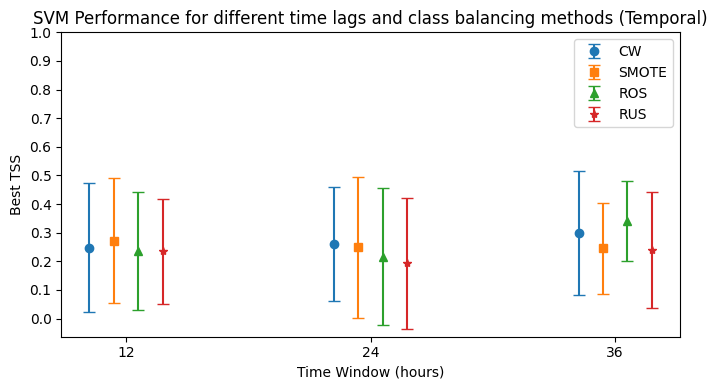

In [23]:
# Read the best TSS including temporal features for differernt sampling methods
cw_t = pd.read_csv('/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_temporal_cw_sampling.csv')
smote_t = pd.read_csv('/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_temporal_smote_sampling.csv')
ROS_t = pd.read_csv('/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_temporal_ROS_sampling.csv')
RUS_t = pd.read_csv('/content/drive/MyDrive/flare_cme/Hemapriya_raju_2023/Results/best_tss_temporal_RUS_sampling.csv')

# Drop the unnamed index column
cw_t = cw_t.drop(columns=['Unnamed: 0'])
smote_t = smote_t.drop(columns=['Unnamed: 0'])
ROS_t = ROS_t.drop(columns=['Unnamed: 0'])
RUS_t = RUS_t.drop(columns=['Unnamed: 0'])

base_times = np.arange(len(cw_t['time']))
offset = 0.1

# Apply small shifts to x positions
cw_time     = base_times - 1.5 * offset
smote_time  = base_times - 0.5 * offset
ros_time    = base_times + 0.5 * offset
rus_time    = base_times + 1.5 * offset

# Create the plot
plt.figure(figsize=(7, 4))

plt.errorbar(cw_time, cw_t["mean_tss"], yerr= cw_t['std_tss'], marker='o',linestyle='None', label='CW',capsize=4)
plt.errorbar(smote_time, smote_t["mean_tss"], yerr= smote_t['std_tss'], marker='s',linestyle='None', label='SMOTE',capsize=4)
plt.errorbar(ros_time, ROS_t["mean_tss"], yerr= ROS_t['std_tss'], marker='^',linestyle='None', label='ROS',capsize=4)
plt.errorbar(rus_time, RUS_t["mean_tss"], yerr= RUS_t['std_tss'], marker='*',linestyle='None', label='RUS',capsize=4)

plt.title('SVM Performance for different time lags and class balancing methods (Temporal)')
plt.xlabel('Time Window (hours)')
plt.ylabel('Best TSS')
plt.xticks(base_times, [12,24,36])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Research/Google Colab/Hemapriya Raju 2023/analysis/svm/tss_comparison_temporal_.png')
plt.show()